### Задание 1
Implement a PyTorch layer (inherit a class from `torch.nn.Module`) for extraction of **logarithms of Mel-scale Filterbank energies** using basic `torch` math operations such as multiplication, power and so on. **[10 pts]**

1. Given a template [melbanks.py](melbanks.py), complete the implementation of class `LogMelFilterBanks`:
    - You're required to finish `LogMelFilterBanks.__init__(self, **kwargs)` and `.forward(self, x)` methods
        - Please note that there are two more methods to implement such as `.spectrogram(self, x)` and `._init_melscale_fbanks(self)`. See code comments with details
        - Your code should replace `<YOUR CODE GOES HERE>` placeholders with your code
    - Implementation notes:
        - In this exercise we use [**hann** window](https://pytorch.org/docs/stable/generated/torch.hann_window.html) only
        - Also, power spectrum of spectrogram has to be used
        - No `torchaudio` functions calls are allowed in this layer implementation other than already provided (i.e. `F.melscale_fbanks()` and `torchaudio.load()` are allowed)
    - Evaluation:
        - For an arbitrary audiofile of 16 kHz sampling frequency, plot the Log MelFilterbanks output versus native `torchaudio.transforms.MelSpectrogram` implementation and attach plots to the report
        - Don't forget that natural `torchaudio.transforms.MelSpectrogram` doesn't apply logarithm
        - Audio file can be loaded using the snippet below
        ```python3
        import torchaudio
        signal, sr = torchaudio.load(<wav_path>)
        ```
        - Your implementation will be checked via the following snippet:
        ```python3
        melspec = torchaudio.transforms.MelSpectrogram(
            hop_length=160,
            n_mels=80
        )(signal)
        logmelbanks = LogMelFilterBanks()(signal)

        assert torch.log(melspec + 1e-6).shape == logmelbanks.shape
        assert torch.allclose(torch.log(melspec + 1e-6), logmelbanks)
        ```
    - Hints:
        - Be careful with `Optional` parameters initialization
        - Use [resources below](#resources) and lecture slides
        - Such simple operators as `torch.abs()`, `torch.log()` and so on should be sufficient to complete this exercise

In [9]:
from typing import Optional
import torch
import torchaudio
from torch import nn
from torchaudio import functional as F


class LogMelFilterBanks(nn.Module):
    def __init__(
            self,
            n_fft: int = 400,
            samplerate: int = 16000,
            hop_length: int = 160,
            n_mels: int = 80,
            pad_mode: str = 'reflect',
            power: float = 2.0,
            normalize_stft: bool = False,
            onesided: bool = True,
            center: bool = True,
            return_complex: bool = True,
            f_min_hz: float = 0.0,
            f_max_hz: Optional[float] = None,
            norm_mel: Optional[str] = None,
            mel_scale: str = 'htk'
        ):
        super(LogMelFilterBanks, self).__init__()
        # general params and params defined by the exercise
        self.n_fft = n_fft
        self.samplerate = samplerate
        self.window_length = n_fft
        self.window = torch.hann_window(self.window_length).to(torch.device("cuda:0"))
        # Do correct initialization of stft params below:
        # hop_length, n_mels, center, return_complex, onesided, normalize_stft, pad_mode, power
        # ...
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.center = center
        self.return_complex  = return_complex
        self.onesided = onesided
        self.normalize_stft = normalize_stft
        self.pad_mode = pad_mode
        self.power = power

        # Do correct initialization of mel fbanks params below:
        # f_min_hz, f_max_hz, norm_mel, mel_scale
        # ...
        self.f_min_hz = f_min_hz
        self.f_max_hz = f_max_hz
        self.norm_mel = norm_mel
        self.mel_scale = mel_scale

        # finish parameters initialization
        self.mel_fbanks = self._init_melscale_fbanks()

    def _init_melscale_fbanks(self):
        # To access attributes, use self.<parameter_name>
        return F.melscale_fbanks(
            int(self.n_fft // 2 + 1),
            n_mels = self.n_mels,
            f_min=self.f_min_hz,
            f_max=self.samplerate / 2,
            sample_rate=self.samplerate,
            norm=self.norm_mel,
            mel_scale=self.mel_scale,
        )

    def spectrogram(self, x):
        # x - is an input signal
        return torch.stft(
            x,
            n_fft = self.n_fft,
            hop_length = self.hop_length,
            win_length = self.window_length,
            window = self.window,
            center = self.center,
            pad_mode = self.pad_mode,
            onesided = self.onesided,
            normalized = self.normalize_stft,
            return_complex = self.return_complex,
        )

    def forward(self, x):
        """
        Args:
            x (Torch.Tensor): Tensor of audio of dimension (batch, time), audiosignal
        Returns:
            Torch.Tensor: Tensor of log mel filterbanks of dimension (batch, n_mels, n_frames),
                where n_frames is a function of the window_length, hop_length and length of audio
        """
        spectrogram = self.spectrogram(x)
        mel_spectrogram = (torch.abs(spectrogram) ** self.power).transpose(1,2) @ self.mel_fbanks.to(torch.device("cuda:0"))
        log_mel_spectrogram = torch.log(mel_spectrogram + 1e-6)
        return log_mel_spectrogram.transpose(1,2)

In [9]:
signal, sr = torchaudio.load("/content/res (4).wav")

In [10]:
melspec = torchaudio.transforms.MelSpectrogram(
    hop_length=160,
    n_mels=80
)(signal)
logmelbanks = LogMelFilterBanks(samplerate=sr)(signal)

assert torch.log(melspec + 1e-6).shape == logmelbanks.shape
assert torch.allclose(torch.log(melspec + 1e-6), logmelbanks)


Реализация pytorch

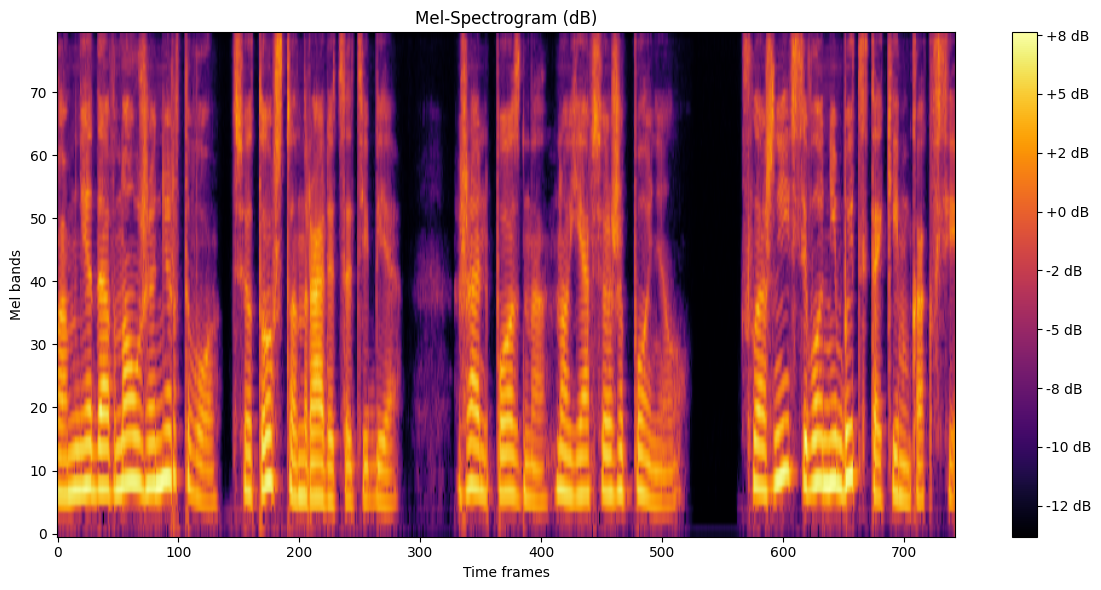

In [11]:
import matplotlib.pyplot as plt
import torchaudio
import torch

# Plotting
plt.figure(figsize=(12, 6))
plt.imshow(torch.log(melspec + 1e-6)[0].numpy(), origin='lower', aspect='auto', cmap='inferno')
plt.title('Mel-Spectrogram (dB)')
plt.xlabel('Time frames')
plt.ylabel('Mel bands')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()


Моя реализация

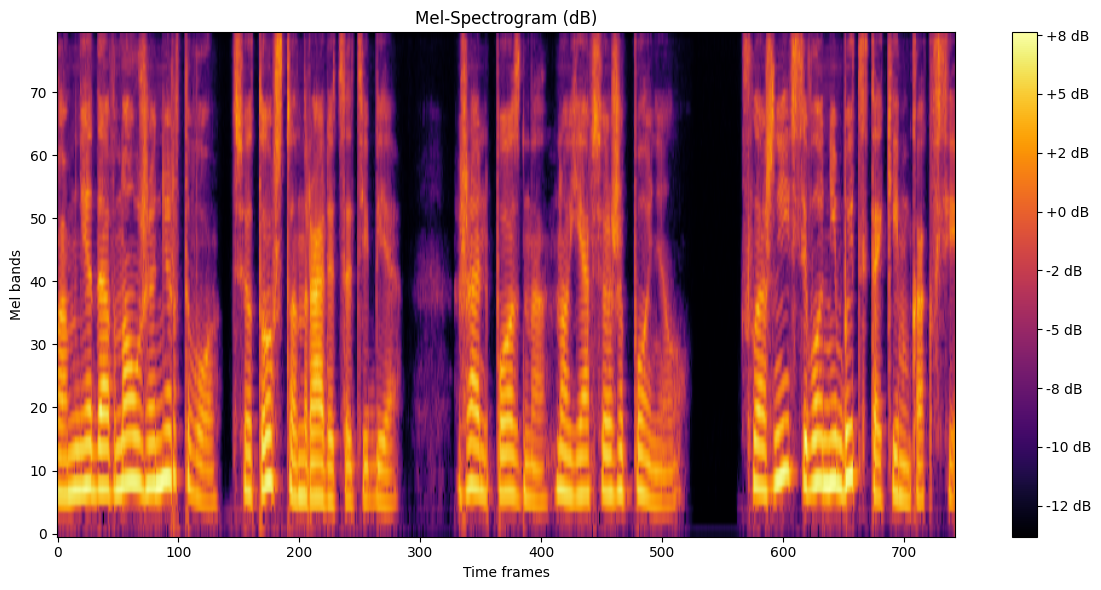

In [12]:
plt.figure(figsize=(12, 6))
plt.imshow(logmelbanks[0].numpy(), origin='lower', aspect='auto', cmap='inferno')
plt.title('Mel-Spectrogram (dB)')
plt.xlabel('Time frames')
plt.ylabel('Mel bands')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

In [13]:
logmelbanks.shape

torch.Size([1, 80, 743])

### Задание 2
Train a simple CNN model with `LogMelFilterBanks` features for a binary classification problem with [**PyTorch**](https://pytorch.org/) on [Google Speech Commands](https://arxiv.org/abs/1804.03209) data. **[20 pts]**


2. Set-up training pipeline:
    - Use `from torchaudio.datasets import SPEECHCOMMANDS` dataset
    - Convert multi-classification problem into a **binary classification** problem by utilization of two `**"YES"**` and `**"NO"**` target classes only
    - Use provided by default training/validation/testing splits of data
    - Define a custom model architecture (based on [`torch.nn.Conv1d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html))
    - You can use [PyTorch Lightning](https://lightning.ai/docs/pytorch/stable/) in this exercise
    - Track (log) **train loss**, **validation accuracy** and **epoch training time** (no matter what batch size is used)
    - Implement model testing on the testing subset with [accuracy](https://developers.google.com/machine-learning/crash-course/classification/accuracy-precision-recall) as a metric
    - Make sure you implement methods that can calculate **number of model parameters** and **FLOPs** (for [FLOPs](https://en.wikipedia.org/wiki/Floating_point_operations_per_second) calculation external library can be imported)


3. Train a model and experiment with a number of filterbanks in `LogMelFilterBanks` layer:
    - Try varying this number (e.g. `n_mels = X  # X from [20, 40, 80]`)
    - Dump to report comparisons and rest of your conclusions:
        - e.g. you can plot **train loss** of different model runs in one graph
        - you can plot **n_mels** vs **testing accuracy** and so on
    - Choose any of trained models as a baseline for the next stage task


4. Experiment with **`groups`** parameter of Conv1d layer:
    ![Group convolution](group_convolution.png)
    - Set this parameter to different values (e.g. one of `{2, 4, 8, 16}`) and train the model (while tracking all the metrics)
    - Attach a graph with dependency of **epoch training time** versus **groups** parameter, as well as **number of model parameters** and **FLOPs** versus **groups** and other
    - Dump to report all your graphs and conclusions

In [7]:
! pip install lightning -q

In [5]:
from torchaudio.datasets import SPEECHCOMMANDS
from torch import optim, nn, utils, Tensor

In [4]:
SPEECHCOMMANDS(root = "./", download=True)

100%|██████████| 2.26G/2.26G [00:27<00:00, 89.5MB/s]


In [2]:
with open("/content/SpeechCommands/speech_commands_v0.02/validation_list.txt", "r") as f:
    text = f.read()
    filtered_text = "\n".join([path for path in text.split("\n") if path.split("/")[0] in ("yes","no")])

with open("/content/SpeechCommands/speech_commands_v0.02/validation_list.txt", "w") as f:
    f.write(filtered_text)

In [3]:
with open("/content/SpeechCommands/speech_commands_v0.02/testing_list.txt", "r") as f:
    text = f.read()
    filtered_text = "\n".join([path for path in text.split("\n") if path.split("/")[0] in ("yes","no")])

with open("/content/SpeechCommands/speech_commands_v0.02/testing_list.txt", "w") as f:
    f.write(filtered_text)

In [6]:
train = SPEECHCOMMANDS(root="./",subset="training")
test = SPEECHCOMMANDS(root="./",subset="testing")
val = SPEECHCOMMANDS(root="./",subset="validation")
train = [sample for sample in train if sample[2].lower() in ['yes', 'no']]


In [10]:
labels = sorted(list(set(datapoint[2] for datapoint in train)))

def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]

def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch

def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform[0]]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 32


train_loader = torch.utils.data.DataLoader(
    train,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
)
test_loader = torch.utils.data.DataLoader(
    test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
)

val_loader = torch.utils.data.DataLoader(
    val,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
)

In [19]:
LogMelFilterBanks(samplerate=16000, n_mels=20)(train[0][0].to("cuda:0")).shape

torch.Size([1, 20, 101])

In [98]:
conv_1 = nn.Conv1d(in_channels=80, out_channels=32, kernel_size=50, groups=2).cuda()
conv_2 = nn.Conv1d(in_channels=32, out_channels=16, kernel_size=10, groups=2).cuda()
conv_3 = nn.Conv1d(in_channels=16, out_channels=, kernel_size=10, groups=2).cuda()
linear = nn.Linear(68, 2).cuda()
conv_3(conv_2(conv_1(LogMelFilterBanks(samplerate=16000, n_mels=80)(torch.randn(32,16000).cuda())))).reshape(32,-1).shape

torch.Size([32, 68])

In [106]:
import lightning as L

class LitConvAudioClassifier(L.LightningModule):
    def __init__(self, n_mels=80, groups=2):
        super().__init__()
        self.n_mels = n_mels
        self.groups = groups

        self.conv_1 = nn.Conv1d(in_channels=n_mels, out_channels=32, kernel_size=50, groups=self.groups)
        self.conv_2 = nn.Conv1d(in_channels=32, out_channels=16, kernel_size=10, groups=self.groups)
        self.conv_3 = nn.Conv1d(in_channels=16, out_channels=2, kernel_size=10, groups=2)
        self.linear = nn.Linear(68, 2)


    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x, y = batch
        batch_size = x.shape[0]
        x_logmel = LogMelFilterBanks(samplerate=16000, n_mels=self.n_mels)(x)
        y_hat = self.linear(self.conv_3(self.conv_2(self.conv_1(x_logmel))).reshape(batch_size,-1))
        loss = nn.functional.cross_entropy(y_hat, y)
        self.log("train_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        batch_size = x.shape[0]
        x_logmel = LogMelFilterBanks(samplerate=16000, n_mels=self.n_mels)(x)
        y_hat = self.linear(self.conv_3(self.conv_2(self.conv_1(x_logmel))).reshape(batch_size,-1))
        preds = torch.argmax(y_hat, dim=1)
        accuracy = (preds == y).float().mean()
        self.log("val_loss", accuracy, on_step=True, prog_bar=True, logger=True)
        return {"loss": accuracy}

    def test_step(self, batch, batch_idx):
        x, y = batch
        batch_size = x.shape[0]
        x_logmel = LogMelFilterBanks(samplerate=16000, n_mels=self.n_mels)(x)
        y_hat = self.linear(self.conv_3(self.conv_2(self.conv_1(x_logmel))).reshape(batch_size,-1))
        preds = torch.argmax(y_hat, dim=1)
        accuracy = (preds == y).float().mean()
        self.log("test_loss", accuracy)
        return {"loss": accuracy}

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def forward(self, x):
        x_logmel = LogMelFilterBanks(samplerate=16000, n_mels=self.n_mels)(x)
        batch_size = x.shape[0]
        return torch.argmax(self.linear(self.conv_3(self.conv_2(self.conv_1(x_logmel))).reshape(batch_size,-1)))




In [50]:
n_mels_params = (20,40,80,120,180)
acc_n_mels = dict()

for n_mels in n_mels_params:
    print(f"n_mels = {n_mels}")
    audio_classifier = LitConvAudioClassifier(n_mels = n_mels)
    trainer = L.Trainer(max_epochs=10, val_check_interval=100)
    trainer.fit(model=audio_classifier, train_dataloaders=train_loader, val_dataloaders=val_loader)
    test_acc = trainer.test(dataloaders=test_loader)
    acc_n_mels[n_mels] = test_acc

INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:lightning.pytorch.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name   | Type   | Params | Mode 
------------------------------------------
0 | conv_1 | Conv1d | 20.0 K | train
1 | conv_2 | Conv1d | 1.0 K  | train
2 | conv_3 | C

n_mels = 20


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO: Restoring states from the checkpoint path at /content/lightning_logs/version_19/checkpoints/epoch=9-step=1891.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_19/checkpoints/epoch=9-step=1891.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/lightning_logs/version_19/checkpoints/epoch=9-step=1891.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_19/checkpoints/epoch=9-step=1891.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.8956310749053955     │
└───────────────────────────┴───────────────────────────┘

INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:lightning.pytorch.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name   | Type   | Params | Mode 
------------------------------------------
0 | conv_1 | Conv1d | 40.0 K | train
1 | conv_2 | Conv1d | 1.0 K  | train
2 | conv_3 | C

n_mels = 40


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO: Restoring states from the checkpoint path at /content/lightning_logs/version_20/checkpoints/epoch=9-step=1891.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_20/checkpoints/epoch=9-step=1891.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/lightning_logs/version_20/checkpoints/epoch=9-step=1891.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_20/checkpoints/epoch=9-step=1891.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.8689320683479309     │
└───────────────────────────┴───────────────────────────┘

INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:lightning.pytorch.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name   | Type   | Params | Mode 
------------------------------------------
0 | conv_1 | Conv1d | 80.0 K | train
1 | conv_2 | Conv1d | 1.0 K  | train
2 | conv_3 | C

n_mels = 80


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO: Restoring states from the checkpoint path at /content/lightning_logs/version_21/checkpoints/epoch=9-step=1891.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_21/checkpoints/epoch=9-step=1891.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/lightning_logs/version_21/checkpoints/epoch=9-step=1891.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_21/checkpoints/epoch=9-step=1891.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.8895630836486816     │
└───────────────────────────┴───────────────────────────┘

INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:lightning.pytorch.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name   | Type   | Params | Mode 
------------------------------------------
0 | conv_1 | Conv1d | 120 K  | train
1 | conv_2 | Conv1d | 1.0 K  | train
2 | conv_3 | C

n_mels = 120


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (120) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO: Restoring states from the checkpoint path at /content/lightning_logs/version_22/checkpoints/epoch=9-step=1891.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_22/checkpoints/epoch=9-step=1891.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/lightning_logs/version_22/checkpoints/epoch=9-step=1891.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_22/checkpoints/epoch=9-step=1891.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.9150485396385193     │
└───────────────────────────┴───────────────────────────┘

INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:lightning.pytorch.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name   | Type   | Params | Mode 
------------------------------------------
0 | conv_1 | Conv1d | 180 K  | train
1 | conv_2 | Conv1d | 1.0 K  | train
2 | conv_3 | C

n_mels = 180


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (180) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO: Restoring states from the checkpoint path at /content/lightning_logs/version_23/checkpoints/epoch=9-step=1891.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_23/checkpoints/epoch=9-step=1891.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/lightning_logs/version_23/checkpoints/epoch=9-step=1891.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_23/checkpoints/epoch=9-step=1891.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.8786407709121704     │
└───────────────────────────┴───────────────────────────┘

In [51]:
acc_n_mels

{20: [{'test_loss': 0.8956310749053955}],
 40: [{'test_loss': 0.8689320683479309}],
 80: [{'test_loss': 0.8895630836486816}],
 120: [{'test_loss': 0.9150485396385193}],
 180: [{'test_loss': 0.8786407709121704}]}

In [31]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
! pip install fvcore -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [39]:
from fvcore.nn import FlopCountAnalysis
audio_classifier.to("cuda:0")
inputs = (torch.randn((16,16000)).to('cuda:0'))
flops = FlopCountAnalysis(audio_classifier, inputs)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name   | Type   | Params | Mode 
------------------------------------------
0 | conv_1 | Conv1d | 64.0 K | train
1 | conv_2 | Conv1d | 2.6 K  | train
2 | conv_3 | Conv1d | 162    | train
3 | linear | Linear | 138    | train
------------------------------------------
66.9 K    Trainable params
0         Non-trainable params
66.9 K    Total params
0.268     Total estimated model params size (MB)
4         Modules in train mode
0     


=== Running experiment with groups = 2 ===


Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/core/module.py:512: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Epoch 0 training time: 1.30 sec
Epoch 1 training time: 1.26 sec
Epoch 2 training time: 1.30 sec
Epoch 3 training time: 1.31 sec
Epoch 4 training time: 1.31 sec
Epoch 5 training time: 1.71 sec
Epoch 6 training time: 1.64 sec
Epoch 7 training time: 1.32 sec
Epoch 8 training time: 1.29 sec


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name   | Type   | Params | Mode 
------------------------------------------
0 | conv_1 | Conv1d | 32.0 K | train
1 | conv_2 | Conv1d | 1.3 K  | train
2 | conv_3 | Conv1d | 162    | train
3 | linear | Linear | 138    | train
------------------------------------------
33.6 K    Trainable params
0         Non-trainable params
33.6 K    Total par

Epoch 9 training time: 1.32 sec
Groups: 2, Avg Epoch Time: 1.38 sec, Params: 66908, FLOPs: 1.62e+08

=== Running experiment with groups = 4 ===


Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/core/module.py:512: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Epoch 0 training time: 1.47 sec
Epoch 1 training time: 1.39 sec
Epoch 2 training time: 1.39 sec
Epoch 3 training time: 1.43 sec
Epoch 4 training time: 1.72 sec
Epoch 5 training time: 1.57 sec
Epoch 6 training time: 1.38 sec
Epoch 7 training time: 1.43 sec
Epoch 8 training time: 1.39 sec


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name   | Type   | Params | Mode 
------------------------------------------
0 | conv_1 | Conv1d | 16.0 K | train
1 | conv_2 | Conv1d | 656    | train
2 | conv_3 | Conv1d | 162    | train
3 | linear | Linear | 138    | train
------------------------------------------
17.0 K    Trainable params
0         Non-trainable params
17.0 K    Total par

Epoch 9 training time: 1.39 sec
Groups: 4, Avg Epoch Time: 1.46 sec, Params: 33628, FLOPs: 1.07e+08

=== Running experiment with groups = 8 ===


Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/core/module.py:512: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Epoch 0 training time: 1.36 sec
Epoch 1 training time: 1.32 sec
Epoch 2 training time: 1.53 sec
Epoch 3 training time: 1.58 sec
Epoch 4 training time: 1.34 sec
Epoch 5 training time: 1.31 sec
Epoch 6 training time: 1.29 sec
Epoch 7 training time: 1.32 sec
Epoch 8 training time: 1.32 sec


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name   | Type   | Params | Mode 
------------------------------------------
0 | conv_1 | Conv1d | 8.0 K  | train
1 | conv_2 | Conv1d | 336    | train
2 | conv_3 | Conv1d | 162    | train
3 | linear | Linear | 138    | train
------------------------------------------
8.7 K     Trainable params
0         Non-trainable params
8.7 K     Total par

Epoch 9 training time: 1.31 sec
Groups: 8, Avg Epoch Time: 1.37 sec, Params: 16988, FLOPs: 7.97e+07

=== Running experiment with groups = 16 ===


Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/core/module.py:512: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Epoch 0 training time: 1.36 sec
Epoch 1 training time: 1.50 sec
Epoch 2 training time: 1.66 sec
Epoch 3 training time: 1.32 sec
Epoch 4 training time: 1.34 sec
Epoch 5 training time: 1.33 sec
Epoch 6 training time: 1.31 sec
Epoch 7 training time: 1.30 sec
Epoch 8 training time: 1.34 sec


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9 training time: 1.38 sec
Groups: 16, Avg Epoch Time: 1.38 sec, Params: 8668, FLOPs: 6.59e+07


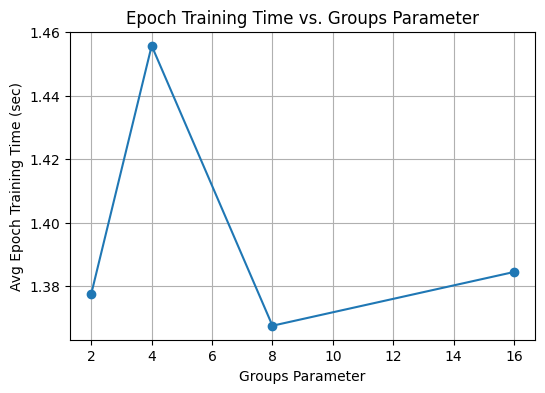

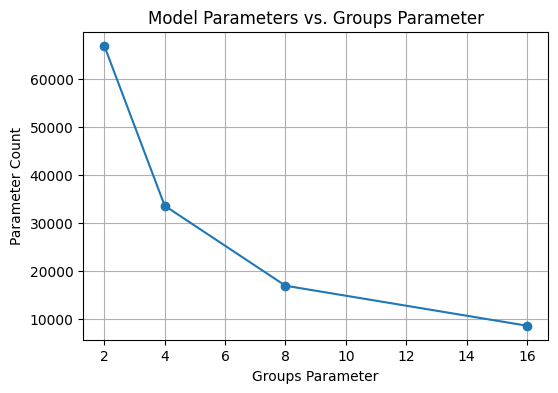

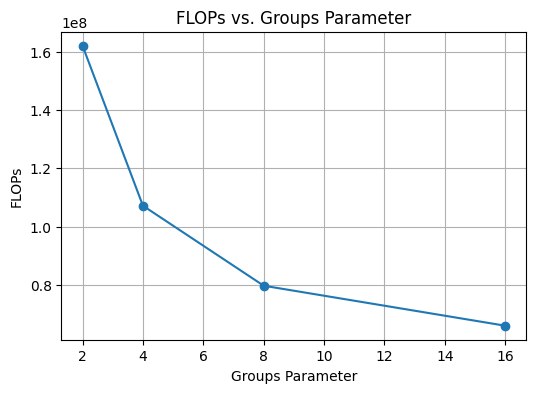

In [109]:
from lightning.pytorch.callbacks import Callback
import time
import numpy as np

import matplotlib.pyplot as plt



class EpochTimeCallback(Callback):
    def on_train_epoch_start(self, trainer, pl_module):
        self.epoch_start_time = time.time()

    def on_train_epoch_end(self, trainer, pl_module):
        epoch_time = time.time() - self.epoch_start_time
        if not hasattr(self, "epoch_times"):
            self.epoch_times = []
        self.epoch_times.append(epoch_time)
        print(f"Epoch {trainer.current_epoch} training time: {epoch_time:.2f} sec")

# --- Helper Functions ---

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def run_experiment(groups_value):
    # Instantiate the model with the given groups value
    model = LitConvAudioClassifier(n_mels=80, groups=groups_value)
    param_count = count_parameters(model)

    # Set up the callback to record training time
    epoch_time_callback = EpochTimeCallback()

    # Train for a few epochs (using CPU; adjust max_epochs or accelerator if needed)
    trainer = L.Trainer(
        max_epochs=10,
        callbacks=[epoch_time_callback],
        logger=False,
        enable_checkpointing=False,
        accelerator="gpu"
    )
    trainer.fit(model, train_loader)

    avg_epoch_time = np.mean(epoch_time_callback.epoch_times)

    # Calculate FLOPs using a dummy input (batch size 16, audio length 16000)
    dummy_input = torch.randn(32, 16000).cuda()
    flops = FlopCountAnalysis(model.cuda(), dummy_input).total()

    return avg_epoch_time, param_count, flops

# --- Main Experiment Loop and Plotting ---

def main():
    groups_list = [2, 4, 8, 16]
    epoch_times = []
    params_list = []
    flops_list = []

    for g in groups_list:
        print(f"\n=== Running experiment with groups = {g} ===")
        avg_time, param_count, flops = run_experiment(g)
        epoch_times.append(avg_time)
        params_list.append(param_count)
        flops_list.append(flops)
        print(f"Groups: {g}, Avg Epoch Time: {avg_time:.2f} sec, Params: {param_count}, FLOPs: {flops:.2e}")

    # Plot: Epoch Training Time vs Groups Parameter
    plt.figure(figsize=(6,4))
    plt.plot(groups_list, epoch_times, marker='o')
    plt.xlabel('Groups Parameter')
    plt.ylabel('Avg Epoch Training Time (sec)')
    plt.title('Epoch Training Time vs. Groups Parameter')
    plt.grid(True)
    plt.savefig('epoch_time_vs_groups.png')
    plt.show()

    # Plot: Model Parameters vs Groups Parameter
    plt.figure(figsize=(6,4))
    plt.plot(groups_list, params_list, marker='o')
    plt.xlabel('Groups Parameter')
    plt.ylabel('Parameter Count')
    plt.title('Model Parameters vs. Groups Parameter')
    plt.grid(True)
    plt.savefig('params_vs_groups.png')
    plt.show()

    # Plot: FLOPs vs Groups Parameter
    plt.figure(figsize=(6,4))
    plt.plot(groups_list, flops_list, marker='o')
    plt.xlabel('Groups Parameter')
    plt.ylabel('FLOPs')
    plt.title('FLOPs vs. Groups Parameter')
    plt.grid(True)
    plt.savefig('flops_vs_groups.png')
    plt.show()

main()